In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

# Hyperparameters

In [2]:
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time

### TODO: Tweak these parameters and see how the results change.
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 1 # Can be 0, 1, 2, or "ALL"
spatial_size = (64, 64) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


y_start_stop_lg = [500, 720] # Min and max in y to search in slide_window()
y_start_stop_md = [500, 644] # Min and max in y to search in slide_window()
y_start_stop_sm = [500, 644] # Min and max in y to search in slide_window()

# Training

In [3]:
# Read in cars and notcars
test_images = glob.glob('data/vehicle_or_not/**/*.jpeg')
test_cars = []
test_notcars = []
for image in test_images:
    if 'image' in image or 'extra' in image:
        test_notcars.append(image)
    else:
        test_cars.append(image)

In [4]:
cars = glob.glob('data/vehicles/**/*.png')
notcars = glob.glob('data/non-vehicles/**/*.png')

print("Cars:", len(cars))
print("Not cars:", len(notcars))

Cars: 8792
Not cars: 8968


In [5]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [6]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print("y: ", y.shape)
print("X: ", scaled_X.shape)
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

y:  (17760,)
X:  (17760, 14100)


In [7]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 14100
84.76 Seconds to train SVC...
Test Accuracy of SVC =  0.9693


# Bounding Box Examples

In [8]:
image = mpimg.imread('data/bbox-example-image.jpg')
draw_image = np.copy(image)


In [9]:

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

def run_image(image):
    
    windows_lg = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop_lg, 
                              xy_window=(96 * 2, 96 * 2), xy_overlap=(0.5, 0.5))
    
    hot_windows_lg = search_windows(image, windows_lg, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    windows_md = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop_md, 
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    
    hot_windows_md = search_windows(image, windows_md, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    windows_sm = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop_sm, 
                        xy_window=(48, 48), xy_overlap=(0.5, 0.5))
    
    hot_windows_sm = search_windows(image, windows_sm, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)     
    
    # Draw Hot windows as red
    window_img = draw_boxes(image, hot_windows_lg, color=(255, 0, 0), thick=6)
    window_img = draw_boxes(draw_image, hot_windows_md, color=(255, 0, 0), thick=6)
    window_img = draw_boxes(draw_image, hot_windows_sm, color=(255, 0, 0), thick=6)

    # draw all windows
    window_img = draw_boxes(window_img, windows_lg, color=(0,255,0), thick=2)
    window_img = draw_boxes(window_img, windows_md, color=(0,0,255), thick=1)
    window_img = draw_boxes(window_img, windows_sm, color=(0,255,255), thick=1)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows_lg)
    heat = add_heat(heat,hot_windows_md)
    heat = add_heat(heat,hot_windows_sm)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return window_img, heatmap, draw_img

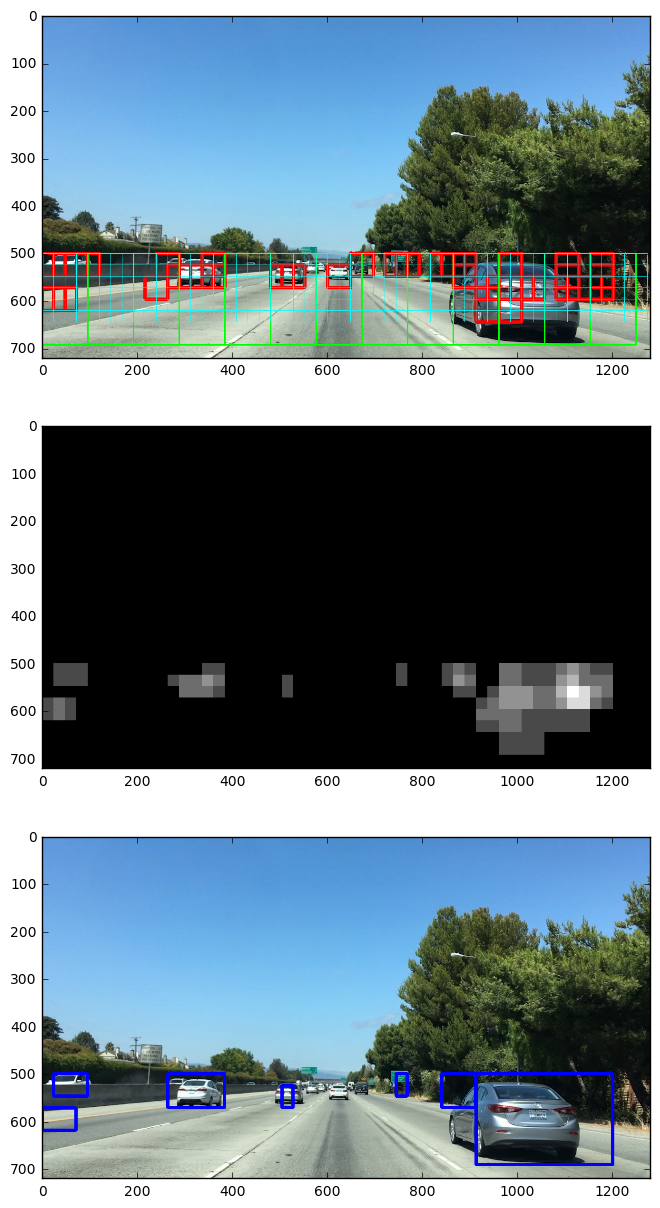

In [10]:
window_img, heatmap, draw_img = run_image(image)
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30, 15))
ax1.imshow(window_img)
ax2.imshow(heatmap, cmap='gray')
ax3.imshow(draw_img)
plt.show()

# Video Pipeline

In [ ]:
def run_vid(img):
    window_img, heatmap, draw_img = run_image(img)
    cv2.imshow("Windows", window_img)
    cv2.imshow("Heatmap", heatmap)
    cv2.imshow("Drawn", draw_img)
    cv2.waitKey(3)
    return heatmap

clip = VideoFileClip("project_video.mp4")
output = clip.fl_image(run_vid)
output.write_videofile("output_images/test.mp4", audio=False)

[MoviePy] >>>> Building video output_images/test.mp4
[MoviePy] Writing video output_images/test.mp4


  4%|▍         | 56/1261 [00:45<16:49,  1.19it/s]